In [19]:
import re
from datetime import datetime

In [20]:
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [21]:
import geopandas as gpd
from pyproj import CRS
from pykml import parser
from shapely.geometry import Point, LineString

In [37]:
path_rec = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\RECORRIDOS.shp'
gdf_rec = gpd.read_file(path_rec)

In [38]:
# Directorio donde están los archivos KML
path_kml = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\TLOGS\ALTA_03'
contenido = os.listdir(path_kml)
len(contenido)

21

In [39]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

0

In [25]:
def extraer_fecha(fecha_txt):
    match = re.search(r"([A-Za-z]{3}-\d{1,2}[a-z]{2}-\d{4})", fecha_txt)
    return match.group(1) if match else None

def format_date(date_str):
    try:
        # Eliminar sufijos ordinales para facilitar la conversión
        date_without_suffix = re.sub(r'(st|nd|rd|th)', '', date_str)
        return pd.to_datetime(date_without_suffix, format='%b-%d-%Y').strftime('%d/%m/%Y')
    except:
        return None

def week_number(date_str):
    """
    Retorna el número de semana del año para una fecha dada en formato "dd/mm/aaaa".
    """
    try:
        date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
        return date_obj.isocalendar()[1]  # El segundo valor de isocalendar() es el número de semana
    except:
        return None

In [26]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [27]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido_filtrado:
    # directorio + nombre de archivo
    path = path_kml + '\\' + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

In [28]:
# dic con la geometria y el file_name
data_lineas = {
    'nombre': file_name,
    'vehiculo': ['DA03']*len(file_name),
    'geometry': lineas
}

In [29]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)
gdf_lineas.crs = "EPSG:4326"
gdf_lineas = gdf_lineas.to_crs(epsg=32720)
gdf_lineas

,nombre,vehiculo,geometry
0,Aug-1st-2024-01-16AM-Flight-Airdata.kml,DA03,"LINESTRING (488348.371 8092376.777, 488348.381..."
1,Aug-1st-2024-02-50AM-Flight-Airdata.kml,DA03,"LINESTRING (500692.062 8098459.747, 500692.030..."
2,Aug-1st-2024-03-35AM-Flight-Airdata.kml,DA03,"LINESTRING (500899.870 8099080.600, 500899.870..."
3,Aug-1st-2024-05-09AM-Flight-Airdata.kml,DA03,"LINESTRING (494680.943 8087721.987, 494680.933..."


<Axes: >

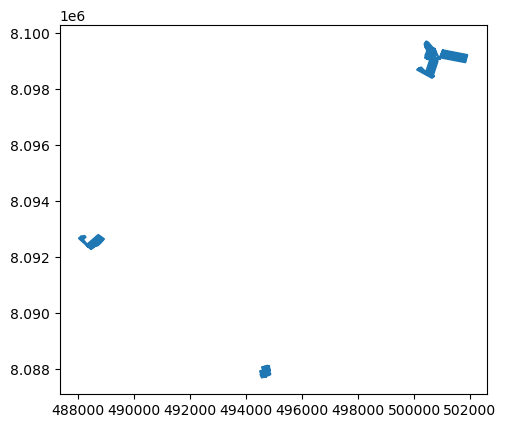

In [30]:
gdf_lineas.plot()

In [31]:
len(gdf_lineas)

4

In [32]:
# Combinar los GeoDataFrames
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_rec, gdf_lineas], ignore_index=True))
# rellenar valores NaN
gdf_combined['idd'] = gdf_combined['idd'].fillna(0).astype(int)

In [33]:
gdf_combined['num_vert'] = gdf_combined['geometry'].apply(contar_coordenadas)

In [34]:
gdf_combined

,idd,nombre,vehiculo,num_vert,geometry
0,0,Jul-20th-2024-08-43PM-Flight-Airdata.kml,DA03,807,"LINESTRING (460257.759 8096126.683, 460257.759..."
1,0,Jul-25th-2024-05-47PM-Flight-Airdata.kml,DA03,931,"LINESTRING (456011.255 8084542.548, 456011.265..."
2,0,Jul-25th-2024-06-51PM-Flight-Airdata.kml,DA03,1168,"LINESTRING (455648.848 8084842.307, 455648.848..."
3,0,Jul-25th-2024-07-06PM-Flight-Airdata.kml,DA03,1581,"LINESTRING (455647.763 8084843.024, 455647.752..."
4,0,Jul-25th-2024-10-42PM-Flight-Airdata.kml,DA03,1225,"LINESTRING (460855.506 8095707.381, 460855.527..."
...,...,...,...,...,...
165,0,2024-07-31 11-18-27,DA02,1503,"LINESTRING (481805.721 8089656.117, 481805.817..."
166,0,Aug-1st-2024-01-16AM-Flight-Airdata.kml,DA03,2160,"LINESTRING (488348.371 8092376.777, 488348.381..."
167,0,Aug-1st-2024-02-50AM-Flight-Airdata.kml,DA03,1497,"LINESTRING (500692.062 8098459.747, 500692.030..."
168,0,Aug-1st-2024-03-35AM-Flight-Airdata.kml,DA03,3324,"LINESTRING (500899.870 8099080.600, 500899.870..."


In [35]:
gdf_combined.dtypes

idd            int32
nombre        object
vehiculo      object
num_vert       int64
geometry    geometry
dtype: object

In [36]:
gdf_combined.to_file(path_rec, driver="ESRI Shapefile")